In [1]:
from collections import defaultdict
import os
import random
import requests
import time
import tqdm

from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ranger import Ranger
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as to
import torch.utils.data as td
from torch.utils.tensorboard import SummaryWriter

In [263]:
# Configuration
device= 'cpu'

# The directory to store the data
data_dir = "data"
train_rating = "ml-1m.train.rating"
test_negative = "ml-1m.test.negative"

batch_size = 128
session_length = 60
embedding_dim = 8 # 64
hidden_dim = 16 # 32
N = 5 # memory size for state_repr
buffer_size = 1000000

In [9]:
def to_np(tensor):
    return tensor.detach().cpu().numpy()

## Environment

In [381]:
class Env():
    def __init__(self, user_item_matrix):
        self.matrix = user_item_matrix
        self.item_count = item_num
        self.memory = np.ones([user_num, N]) * item_num

    def reset(self, user_id):
        self.user_id = user_id
        self.viewed_items = []
        self.related_items = np.argwhere(self.matrix[self.user_id] > 0)[:, 1]
        self.num_rele = len(self.related_items)
        self.nonrelated_items = np.random.choice(
            list(set(range(self.item_count)) - set(self.related_items) - set(viewed_items)), self.num_rele)
        self.available_items = np.zeros(self.num_rele * 2)
        self.available_items[::2] = self.related_items
        self.available_items[1::2] = self.nonrelated_items
        
        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :])
    
    def step(self, action, action_emb=None, buffer=None):
        initial_user = self.user_id
        initial_memory = self.memory[[initial_user], :]
        
        reward = float(to_np(action)[0] in self.related_items)
        self.viewed_items.append(to_np(action)[0])
        if reward:
            if len(action) == 1:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action]
            else:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action[0]]
                
        if buffer is not None:
            buffer.push(np.array([initial_user]), np.array(initial_memory), to_np(action_emb)[0], 
                        np.array([reward]), np.array([self.user_id]), self.memory[[self.user_id], :])
            
        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :]), reward

Use Movielens 1M data from the https://github.com/hexiangnan/neural_collaborative_filtering

In [3]:
if not os.path.isdir('./data'):
    os.mkdir('./data')
    
for file_name in [train_rating, test_negative]:
    file_path = os.path.join(data_dir, file_name)
    if os.path.exists(file_path):
        print("Skip loading " + file_name)
        continue
    with open(file_path, "wb") as tf:
        print("Load " + file_name)
        r = requests.get("https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/" + file_name)
        tf.write(r.content)

Skip loading ml-1m.train.rating
Skip loading ml-1m.test.negative


In [4]:
def preprocess_data():
    data = pd.read_csv(os.path.join(data_dir, train_rating), sep='\t', header=None, 
                             names=['user', 'item', 'rating'], usecols=[0, 1, 2], 
                             dtype={0: np.int32, 1: np.int32, 2: np.int8})
    data = data[data['rating'] > 3][['user', 'item']]
    user_num = data['user'].max() + 1
    item_num = data['item'].max() + 1

    train_mat = defaultdict(int)
    test_mat = defaultdict(int)
    
    train_data = data.sample(frac=0.8, random_state=16)
    test_data = data.drop(train_data.index).values.tolist()
    train_data = train_data.values.tolist()
    
    for user, item in train_data:
        train_mat[user, item] = 1.0
    for user, item in test_data:
        test_mat[user, item] = 1.0
        
    # Convert ratings as a dok matrix
    train_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    dict.update(train_matrix, train_mat)
    test_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    dict.update(test_matrix, test_mat)
    
    return train_data, train_matrix, test_data, test_matrix, user_num, item_num

train_data, train_matrix, test_data, test_matrix, user_num, item_num = preprocess_data()

In [5]:
class EvalDataset(td.Dataset):
    
    def __init__(self, positive_data, item_num, positive_mat, negative_samples=99, valid=True):
        super(EvalDataset, self).__init__()
        self.positive_data = np.array(positive_data)
        self.item_num = item_num
        self.positive_mat = positive_mat
        self.negative_samples = negative_samples
        self.valid = valid
        
        self.reset()
        
    def reset(self):
        print("Resetting dataset")
        negative_data = self.sample_negatives()
        if self.valid:
            data = self.create_valid_data()
            labels = np.zeros(len(self.positive_data) * (1 + self.negative_samples))
            labels[::1+self.negative_samples] = 1
        else:
            data = self.positive_data + negative_data
            labels = [1] * len(self.positive_data) + [0] * len(negative_data)
            
        self.data = np.concatenate([
            np.array(data), 
            np.array(labels)[:, np.newaxis]], 
            axis=1
        )

    def sample_negatives(self):
        negative_data = []
        for user, positive in self.positive_data:
            for _ in range(self.negative_samples):
                negative = np.random.randint(self.item_num)
                while (user, negative) in self.positive_mat:
                    negative = np.random.randint(self.item_num)
                negative_data.append([user, negative])

        return negative_data

    def create_valid_data(self):
        valid_data = []
        for user, positive in self.positive_data:
            valid_data.append([user, positive])
            for i in range(self.negative_samples):
                negative = np.random.randint(self.item_num)
                while (user, negative) in self.positive_mat:
                    negative = np.random.randint(self.item_num)
                    
                valid_data.append([user, negative])

        return valid_data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        output = {
            "user": user,
            "item": item,
            "label": np.float32(label),
        }
        return output

class SamplerWithReset(td.RandomSampler):
    def __iter__(self):
        self.data_source.reset()
        return super().__iter__()

In [291]:
# just one user for evaluation speed
valid_dataset = EvalDataset(
    np.array(test_data)[np.array(test_data)[:, 0] == 6039], 
    item_num, 
    test_matrix)

valid_loader = td.DataLoader(
    valid_dataset, 
    batch_size=100, 
    shuffle=False, 
    num_workers=8
)

Resetting dataset


In [7]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity=buffer_size, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, user, memory, action, reward, next_user, next_memory):
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((user, memory, action, reward, next_user, next_memory))
        else:
            self.buffer[self.pos] = (user, memory, action, reward, next_user, next_memory)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)

        batch       = list(zip(*samples))
        user        = np.concatenate(batch[0])
        memory      = np.concatenate(batch[1])
        action      = batch[2]
        reward      = batch[3]
        next_user   = np.concatenate(batch[4])
        next_memory = np.concatenate(batch[5])

        return user, memory, action, reward, next_user, next_memory

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

In [8]:
beta_start = 0.4
beta_steps = 10000

def get_beta(idx):
    return min(1.0, beta_start + idx * (1.0 - beta_start) / beta_steps)

## Model

In [73]:
class State_Repr_Module(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num+1, embedding_dim, padding_idx=int(item_num))
        self.drr_ave = torch.nn.Conv1d(in_channels=N, out_channels=1, kernel_size=1)
        
        self.initialize()
            
    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        self.item_embeddings.weight.data[-1].zero_()
        nn.init.uniform_(self.drr_ave.weight)
        self.drr_ave.bias.data.zero_()
        
    def forward(self, user, memory):
        user_embedding = self.user_embeddings(user.long())

        item_embeddings = self.item_embeddings(memory.long())
        drr_ave = self.drr_ave(item_embeddings).squeeze(1)
        
        return torch.cat((user_embedding, user_embedding * drr_ave, drr_ave), 1)

In [274]:
class Actor_DRR(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim * 3, hidden_dim),
            nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        
        self.initialize()

    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
            
    def forward(self, state):
        return self.layers(state)
    
    def get_action(self, user, memory, state_repr, 
                   items=torch.tensor([i for i in range(item_num)]), 
                   return_scores=False):
        state = state_repr(user, memory)
        scores = torch.bmm(state_repr.item_embeddings(items).unsqueeze(0), 
                         self.forward(state).T.unsqueeze(0)).squeeze(0)#.squeeze(-1)
        if return_scores:
            return scores, torch.gather(items, 0, scores.argmax(0))
        else:
            return torch.gather(items, 0, scores.argmax(0))

In [361]:
class Critic_DRR(nn.Module):
    def __init__(self, state_repr_dim, action_emb_dim, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_repr_dim + action_emb_dim, hidden_dim), 
            nn.ReLU(), 
#             nn.Linear(hidden_dim, hidden_dim), 
#             nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
        )

        self.initialize()
        
    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.layers(x)
        return x

In [14]:
def hit_metric(recommended, actual):
    return int(actual in recommended)

def dcg_metric(recommended, actual):
    if actual in recommended:
        index = recommended.index(actual)
        return np.reciprocal(np.log2(index + 2))
    return 0

In [292]:
def run_evaluation(net, state_representation, training_env, loader=valid_loader):
    hits = []
    dcgs = []
    test_env = Env(test_matrix)
    test_env.memory = training_env.memory.copy()
    user, memory = test_env.reset(int(to_np(next(iter(valid_loader))['user'])[0]))
    for batch in loader:
        scores, action = net.get_action(
            batch['user'].to(device), 
            torch.tensor(test_env.memory[to_np(batch['user']).astype(int), :]).to(device), 
            state_repr, 
            batch['item'].long().to(device), 
            return_scores=True
        )
        user, memory, reward = test_env.step(action)

        _, ind = scores[:, 0].topk(10)
        predictions = torch.take(batch['item'].to(device), ind).cpu().numpy().tolist()
        actual = batch['item'][0].item()
        hits.append(hit_metric(predictions, actual))
        dcgs.append(dcg_metric(predictions, actual))
        
    return np.mean(hits), np.mean(dcgs)

## Training

In [401]:
state_repr = State_Repr_Module(user_num, item_num, embedding_dim, hidden_dim).to(device)
value_net  = Critic_DRR(embedding_dim * 3, embedding_dim, hidden_dim).to(device)
policy_net = Actor_DRR(embedding_dim, hidden_dim).to(device)
replay_buffer = NaivePrioritizedBuffer(buffer_size)

target_value_net  = Critic_DRR(embedding_dim * 3, embedding_dim, hidden_dim).to(device)
target_policy_net = Actor_DRR(embedding_dim, hidden_dim).to(device).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion  = nn.MSELoss()
value_optimizer  = Ranger(value_net.parameters(),  lr=1e-5, weight_decay=1e-4)
policy_optimizer = Ranger(policy_net.parameters(), lr=1e-5)#, weight_decay=1e-5)
state_repr_optimizer = Ranger(state_repr.parameters(), lr=1e-5, weight_decay=1e-3)

writer = SummaryWriter(log_dir='logs/log9')

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [349]:
!rm logs/log8/*

In [407]:
def ddpg_update(training_env, 
                step=0,
                batch_size=batch_size, 
                gamma=0.8,
                min_value=-10,
                max_value=10,
                soft_tau=0.01,
               ):
    beta = get_beta(step)
    user, memory, action, reward, next_user, next_memory = replay_buffer.sample(batch_size, beta)
    user        = torch.FloatTensor(user).to(device)
    memory      = torch.FloatTensor(memory).to(device)
    action      = torch.FloatTensor(action).to(device)
    reward      = torch.FloatTensor(reward).to(device)
    next_user   = torch.FloatTensor(next_user).to(device)
    next_memory = torch.FloatTensor(next_memory).to(device)
    
    state       = state_repr(user, memory)
    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()
    
    next_state     = state_repr(next_user, next_memory)
    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    state_repr_optimizer.zero_grad()
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()
    state_repr_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    writer.add_histogram('value', value, step)
    writer.add_histogram('target_value', target_value, step)
    writer.add_histogram('expected_value', expected_value, step)
    writer.add_histogram('policy_loss', policy_loss, step)

In [439]:
np.random.seed(16)
train_env = Env(train_matrix)
step = 0
hits = []
dcgs = []
for _ in tqdm.notebook.tqdm(range(100)):
    appropriate_users = np.arange(user_num).reshape(-1, 1)[(train_matrix.sum(1) >= 20)]
    users = np.random.permutation(appropriate_users[appropriate_users > 6000])
    
    for user_id in range(len(users)):
        user, memory = train_env.reset(users[user_id])
        for t in range(int(train_matrix[users[user_id]].sum())):
            action_emb = policy_net(state_repr(user, memory))
            action = policy_net.get_action(
                user.to(device), 
                torch.tensor(train_env.memory[to_np(user).astype(int), :]).to(device), 
                state_repr, 
                torch.tensor(
                    [item for item in train_env.available_items 
                    if item not in train_env.viewed_items]
                ).long().to(device)
            )

            user, memory, reward = train_env.step(
                action, 
                action_emb,
                buffer=replay_buffer
            )

            if len(replay_buffer) > batch_size:
                ddpg_update(train_env, step=step)
                
            step += 1
            if step % 100 == 0:
                hit, dcg = run_evaluation(policy_net, state_repr, train_env)
                writer.add_scalar('hit', hit, step)
                writer.add_scalar('dcg', dcg, step)
                hits.append(hit)
                dcgs.append(dcg)

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-_2tdb3q3'
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-

KeyboardInterrupt: 

## This experiment is the first where hits > 0.3

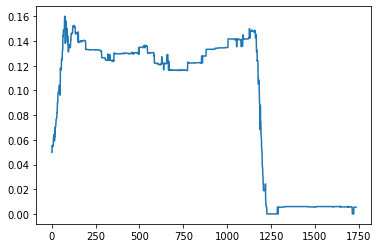

In [443]:
plt.plot(dcgs);

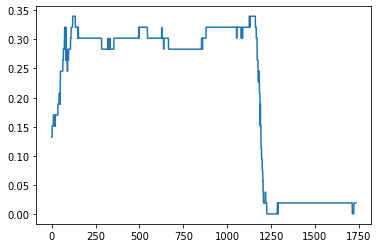

In [444]:
plt.plot(hits);